### The Logistic Regression Classification involves the following tasks:

Step 1: Quick Overview of the Data Structure

Step 2: Prepare Dataset (Training, Validation, and Test Data)

Step 3: Discover and Visualize the Data

Step 4: Data Preprocessing

Step 5: Model Selection and Training

Step 6: Evalute Models and Feature Importance on the Test Data

Import libraries

In [125]:
import os
import pandas as pd
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

Import the dataset 

In [126]:
df=pd.read_csv('data/ps2_available_dataset.csv')

### Step 1: Quick Overview of the Data Structure

In [127]:
#check variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   treatment       10000 non-null  int64  
 1   age             10000 non-null  int64  
 2   blood_pressure  10000 non-null  float64
 3   gender          10000 non-null  object 
 4   blood_test      10000 non-null  object 
 5   family_history  7068 non-null   object 
 6   MeasureA        10000 non-null  float64
 7   TestB           10000 non-null  float64
 8   GeneA           10000 non-null  object 
 9   GeneB           10000 non-null  int64  
 10  GeneC           10000 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 859.5+ KB


In [128]:
df.head()

,treatment,age,blood_pressure,gender,blood_test,family_history,MeasureA,TestB,GeneA,GeneB,GeneC
0,1,74,94.113373,non-female,negative,False,-11.035690,-0.336843,double,1,0
1,1,56,83.337745,non-female,negative,False,-3.982345,-0.018734,none,1,1
2,0,37,81.759240,female,negative,False,6.205701,0.147933,double,1,1
3,1,54,88.549518,female,negative,False,-1.827613,-0.338373,none,1,1
4,0,73,82.171555,female,negative,NaN,-14.637389,-0.369325,none,1,1


Snapshot of histogram for numerical variables (Geron, 2019)

From the histograms below, we see that GeneB, GeneC and treatment are binary variables. MeasureA variable has a normal distribution, while TestB is right skewed, which means I need to standardize all independent numerical variables in the future steps.

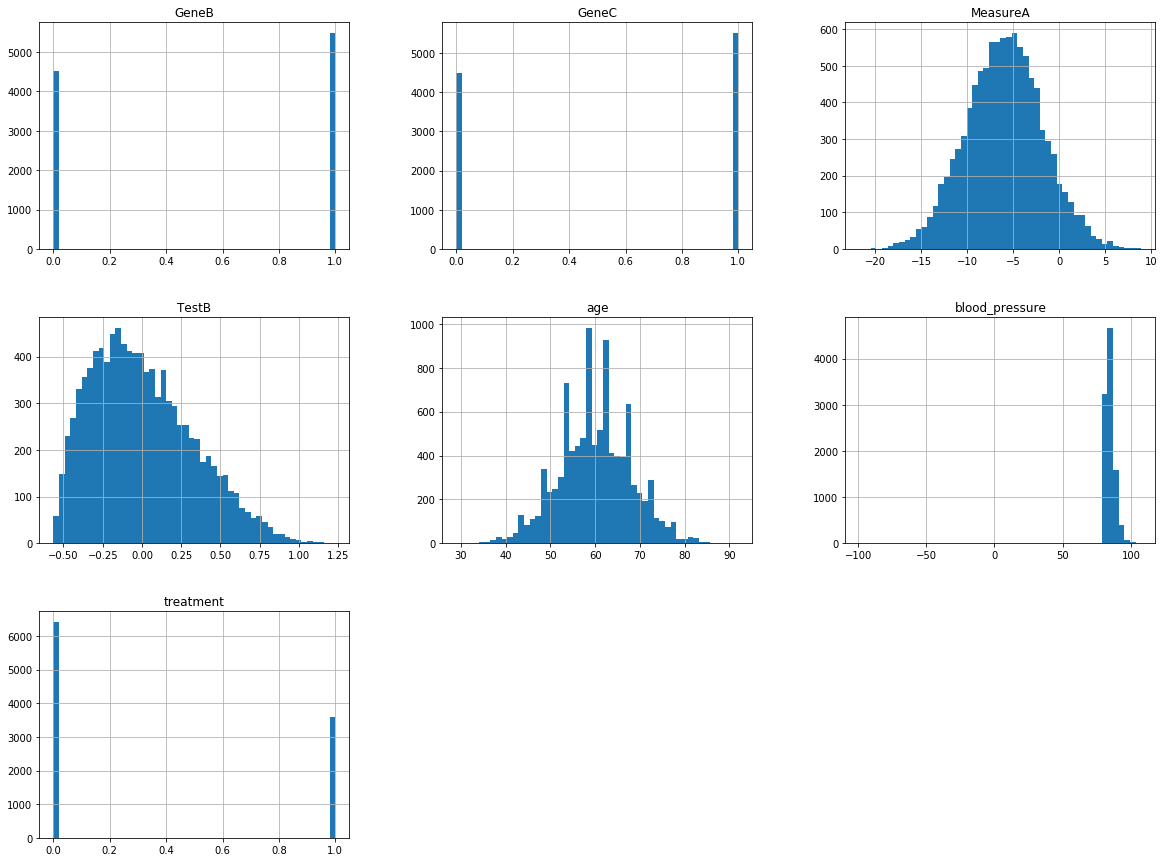

In [129]:
df.hist(bins=50, figsize=(20,15)) 
plt.show()

Descriptive information of the dataset

In [130]:
df.describe()

,treatment,age,blood_pressure,MeasureA,TestB,GeneB,GeneC
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.358700,60.032800,84.642355,-5.992414,0.004466,0.547900,0.550400
std,0.479643,8.106546,5.266045,4.168837,0.322338,0.497725,0.497478
min,0.000000,29.000000,-99.000000,-21.708000,-0.564197,0.000000,0.000000
25%,0.000000,55.000000,82.314030,-8.790691,-0.251337,0.000000,0.000000
50%,0.000000,60.000000,83.997305,-5.956422,-0.039662,1.000000,1.000000
75%,1.000000,66.000000,86.342954,-3.217110,0.215928,1.000000,1.000000
max,1.000000,92.000000,107.595583,8.889658,1.231447,1.000000,1.000000


Show the distribution by percentage of binary and categorial variables

Based on the distribution of categorical variables, we see there are only 70% of data samples that provide the information for family history, and only 0.01% of samples show positive result for family history. Due to the data incompleteness  and skewed frequency distribution, we would remove this variable in the future data processing.

In [131]:
def show_cat_distribution(df,x):
    return print(df[x].value_counts()/len(df))

categorical_features=['treatment','gender','blood_test','family_history','GeneA']
for x in categorical_features:
    show_cat_distribution(df,x)
    print('\n')

0    0.6413
1    0.3587
Name: treatment, dtype: float64


female        0.6362
non-female    0.3638
Name: gender, dtype: float64


negative    0.9067
positive    0.0933
Name: blood_test, dtype: float64


False    0.6968
True     0.0100
Name: family_history, dtype: float64


none      0.4482
double    0.3479
single    0.2039
Name: GeneA, dtype: float64




### Step 2: Prepare Dataset (Training, Validation, and Test Data)

Use stratified sampling method to generate training and test data (Geron, 2019). 
The sampling is based on a categorical variable: 'gender'. This variable was selected because it is most likely to influence the treatment recommendation and there is uneven distribution between female and non-female, considering the percentages of them in the real world are roughly equal.

Test size of 0.1 is selected because I want to save more data for training and fine-tuning models, while 10% of the entire dataset is 1,000 data points, which should be sufficient for testing the results.


In [132]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df,df['gender']):
    strat_train_set = df.loc[train_index]
    strat_test_set=df.loc[test_index]

Verify the percentage distribution of training and test data based on 'gender' categories.

According to the percentage distribution of training and test datasets, we are confident that our stratified sampling has similar distribution with our original dataset

In [133]:
show_cat_distribution(df,'gender')
show_cat_distribution(strat_train_set,'gender')
show_cat_distribution(strat_test_set,'gender')

female        0.6362
non-female    0.3638
Name: gender, dtype: float64
female        0.636222
non-female    0.363778
Name: gender, dtype: float64
female        0.636
non-female    0.364
Name: gender, dtype: float64


### Step 3: Discover and Visualize the Data

Prepare a copy of the training data in case we need to retrieve the original training data (Geron, 2019)

In [134]:
treatment=strat_train_set.copy()

Check the correlation between all numerial variables (Geron, 2019)

In [135]:
corr_matrix =treatment.corr()
corr_matrix

,treatment,age,blood_pressure,MeasureA,TestB,GeneB,GeneC
treatment,1.000000,-0.156017,0.062789,0.152187,0.059160,0.024736,0.044693
age,-0.156017,1.000000,0.002939,-0.970905,-0.001598,0.016377,0.012388
blood_pressure,0.062789,0.002939,1.000000,-0.001722,-0.001108,0.009965,-0.008390
MeasureA,0.152187,-0.970905,-0.001722,1.000000,0.000963,-0.016682,-0.012213
TestB,0.059160,-0.001598,-0.001108,0.000963,1.000000,-0.016238,0.007599
GeneB,0.024736,0.016377,0.009965,-0.016682,-0.016238,1.000000,0.007339
GeneC,0.044693,0.012388,-0.008390,-0.012213,0.007599,0.007339,1.000000


Plot the correlation between all numerial variables (Geron, 2019)

From graphs below, we see that 'age' and 'MeasureA' are highly correlated (-0.97), and none of the other paired variables have such a strong relationship. Having two variables that are highly correlated might lead to difficulties when interpreting predictors (James, 2017). Since age receives a correlation with treatment that is slightly higher than MeasureA, and MeasureA is also more expensive to collect, I would recommend dropping MeasureA in the future modeling. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24d4da90>,
      dtype=object)

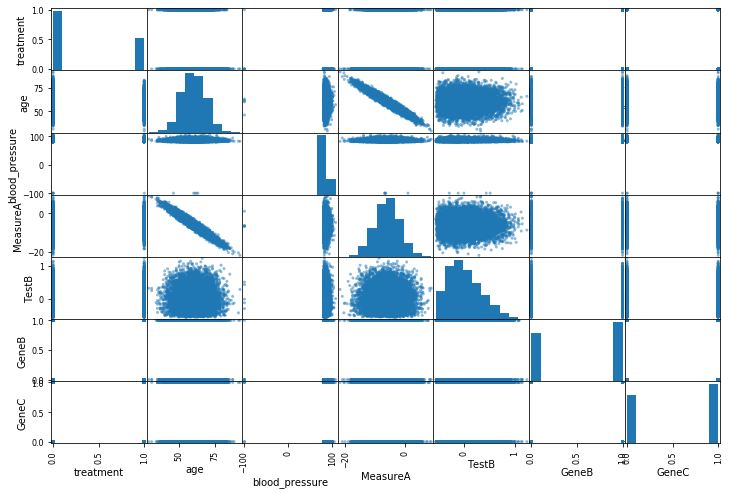

In [136]:
from pandas.plotting import scatter_matrix

scatter_matrix(treatment,figsize=(12,8))

A finalized version of dataset with both predictors and response and without dropped variables is shown below. Additionally, TestB values have been converted to their absolute values and new correlation matrix is shown below.

In [137]:
treatment=treatment.drop(columns=['family_history','MeasureA']) 
treatment['TestB']=np.absolute(treatment.TestB)
treatment.head()

,treatment,age,blood_pressure,gender,blood_test,TestB,GeneA,GeneB,GeneC
132,0,55,84.854349,female,negative,0.226105,double,0,1
2493,0,58,85.361421,female,negative,0.063230,single,1,1
3375,1,74,82.578255,female,negative,0.594239,double,0,0
6227,1,69,89.199884,non-female,negative,0.389893,single,1,1
3845,1,46,81.760122,female,negative,0.339592,double,1,1


In [138]:
corr_matrix =treatment.corr()
corr_matrix

,treatment,age,blood_pressure,TestB,GeneB,GeneC
treatment,1.000000,-0.156017,0.062789,0.357935,0.024736,0.044693
age,-0.156017,1.000000,0.002939,0.001893,0.016377,0.012388
blood_pressure,0.062789,0.002939,1.000000,-0.001941,0.009965,-0.008390
TestB,0.357935,0.001893,-0.001941,1.000000,0.007653,-0.000911
GeneB,0.024736,0.016377,0.009965,0.007653,1.000000,0.007339
GeneC,0.044693,0.012388,-0.008390,-0.000911,0.007339,1.000000


### Step 4: Data Preprocessing

After we explored and made some modification to the training dataset in the last step, we would copy the original training data again for the future data processing (Geron, 2019)

In [139]:
treatment=strat_train_set.copy()

We define a data_transform function here to reflect that we are dropping 'family_history' and 'MeasureA' variables for the reasons we discussed above. 

We do this pre-transformation step before we drop 'price' variable beacuse we want to make sure the same data points would be dropped when we separate dependent and indepedent variables. We also drop the categorical variable GeneA because after a series of feature combination trails, excluding GeneA would considerably improve the AUC scores and interpretability of the best Logistic model. 

For categorical variables, there are only 70% of data samples that provide the information for family history, and only 0.01% of samples show positive result for family history. Due to the data incompleteness and skewed frequency distribution, I removed this variable from categorial variables in the future data processing. I also dropped the categorical variable GeneA because after a series of feature combination trails, excluding GeneA would considerably improve the AUC scores by 15% and enhance the interpretability of the Logistic model.

We choose to drop the data points with any missing values because they only occupy a small percetage of the whole training data.

In [140]:
def data_transform(df):
    df=df.drop(columns=['family_history','MeasureA','GeneA']) 
    df['TestB']=np.absolute(df.TestB)
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna() # Drop the data points with any missing values because they only occupy a small percetage of the whole training data
    return df

In [141]:
treatment=data_transform(treatment)
treatment.head()

,treatment,age,blood_pressure,gender,blood_test,TestB,GeneB,GeneC
132,0,55,84.854349,female,negative,0.226105,0,1
2493,0,58,85.361421,female,negative,0.063230,1,1
3375,1,74,82.578255,female,negative,0.594239,0,0
6227,1,69,89.199884,non-female,negative,0.389893,1,1
3845,1,46,81.760122,female,negative,0.339592,1,1


Drop the dependent variable and create a copy of the dependent variable for model training in the future (Geron, 2019).

In [142]:
treatment_labels=treatment['treatment'].copy()
treatment=treatment.drop('treatment',axis=1)
treatment.head()

,age,blood_pressure,gender,blood_test,TestB,GeneB,GeneC
132,55,84.854349,female,negative,0.226105,0,1
2493,58,85.361421,female,negative,0.063230,1,1
3375,74,82.578255,female,negative,0.594239,0,0
6227,69,89.199884,non-female,negative,0.389893,1,1
3845,46,81.760122,female,negative,0.339592,1,1


Separate numerial and categorical variables for designing a work pipline and further data processing (Geron, 2019)

In [143]:
treatment_num=treatment[['age','blood_pressure','TestB','GeneB','GeneC']]
treatment_cat=treatment[['gender', 'blood_test']]

Use transformation piplines for standarding numerical variables and encoding categorical variables (Geron, 2019).

I first create a pipeline for numerical variables. Standardization is selected because it is more robust to outliers compared to normalization. 


Secondly, I create a pipeline for both numerical and categorical variables. OneHotEncoder is used for transforming categorial variables into dummy variables because there is no clear ordinal relationship in all categorical variables.

In [144]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler 

# Create a pipeline for numerical variables
# Standardization is selected because it is more robust to outliers compared to normalization. 
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(treatment_num)
cat_attribs = list(treatment_cat)

# Create a pipeline for both numerical and categorical variables
# OneHotEncoder is used for transforming categorial variables into dummy variables 
# because there is no clear ordinal relationship in all categorical variables

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

treatment_prepared = full_pipeline.fit_transform(treatment)

Output a 9000*9 data array for future modeling

In [145]:
treatment_prepared # (Geron, 2019)

array([[-0.61408298,  0.04331346, -0.19852095, ...,  0.        ,
         1.        ,  0.        ],
       [-0.24484549,  0.13663357, -1.07937558, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.72442116, -0.37557281,  1.79240862, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.98594617,  0.48389651,  0.60522755, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.12439201, -0.47884078, -0.87538871, ...,  0.        ,
         1.        ,  0.        ],
       [-0.36792465, -0.12640745,  1.1655251 , ...,  0.        ,
         1.        ,  0.        ]])

Print the shape of the data array above

In [146]:
treatment_prepared.shape

(9000, 9)

### Step 5: Model Selection and Training

Logistic Regression Sklearn Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### Preliminary comparision of different models

Import Logistic regression model from sklearn library (Sklearn Documentation, 2020).

Different combinations of penalty (none, l2, l1 and elasticNet) and solver (sage and lbfgs) were used for model selection. 

The accuracy scores are not optimal scores for selecting logistic regression models, they were printed here for a preliminary comparison.

In [147]:
from sklearn.linear_model import LogisticRegression
clf_none= LogisticRegression(random_state=42,penalty='none').fit(treatment_prepared, treatment_labels)
clf_Ridge = LogisticRegression(random_state=42,penalty='l2').fit(treatment_prepared, treatment_labels)
clf_Lasso = LogisticRegression(random_state=42,penalty='l1',solver='saga').fit(treatment_prepared, treatment_labels)
clf_elasticnet = LogisticRegression(random_state=42,penalty='elasticnet',solver='saga',l1_ratio=0.5).fit(treatment_prepared, treatment_labels)

print("The score of Logistic regression without any regularization is : " +str(clf_none.score(treatment_prepared, treatment_labels)))
print("The score of Logistic regression with L2 panelty is " +str(clf_Ridge.score(treatment_prepared, treatment_labels)))
print("The score of Logistic regression with L1 panelty is " +str(clf_Lasso.score(treatment_prepared, treatment_labels)))
print("The score of Logistic regression with elasticNet panelty is " +str(clf_elasticnet.score(treatment_prepared, treatment_labels)))


The score of Logistic regression without any regularization is : 0.7472222222222222
The score of Logistic regression with L2 panelty is 0.7472222222222222
The score of Logistic regression with L1 panelty is 0.7473333333333333
The score of Logistic regression with elasticNet panelty is 0.7473333333333333


Both precision score and recall score were printed for each model.

In [148]:
from sklearn.metrics import precision_score, recall_score 
treatment_predictions_none = clf_none.predict(treatment_prepared)
treatment_predictions_Ridge = clf_Ridge.predict(treatment_prepared)
treatment_predictions_Lasso = clf_Lasso.predict(treatment_prepared)
treatment_predictions_elasticNet = clf_elasticnet.predict(treatment_prepared)


print("The precision score of Logistic regression without any regularization is : " +str(precision_score(treatment_labels,treatment_predictions_none)))
print("The recall score of Logistic regression without any regularization is : " +str(recall_score(treatment_labels,treatment_predictions_none)))
print("The precision score of Logistic regression with L2 panelty is : " +str(precision_score(treatment_labels,treatment_predictions_Ridge)))
print("The recall score of Logistic regression with L2 panelty is : " +str(recall_score(treatment_labels,treatment_predictions_Ridge)))
print("The precision score of Logistic regression with L1 panelty is : " +str(precision_score(treatment_labels,treatment_predictions_Lasso)))
print("The recall score of Logistic regression with L1 panelty is : " +str(recall_score(treatment_labels,treatment_predictions_Lasso)))
print("The precision score of Logistic regression with elasticNet panelty is : " +str(precision_score(treatment_labels,treatment_predictions_elasticNet)))
print("The recall score of Logistic regression with elasticNet panelty is : " +str(recall_score(treatment_labels,treatment_predictions_elasticNet)))


The precision score of Logistic regression without any regularization is : 0.6820695102685624
The recall score of Logistic regression without any regularization is : 0.5401939318110729
The precision score of Logistic regression with L2 panelty is : 0.6820695102685624
The recall score of Logistic regression with L2 panelty is : 0.5401939318110729
The precision score of Logistic regression with L1 panelty is : 0.6823389964440932
The recall score of Logistic regression with L1 panelty is : 0.5401939318110729
The precision score of Logistic regression with elasticNet panelty is : 0.6823389964440932
The recall score of Logistic regression with elasticNet panelty is : 0.5401939318110729


Plot the ROC curve of the four Logistic Regression models by using cross-validation method to collect a series of true positive and false positive  rates with different  threshold settings. The four models are shown in a same graph. Since they have a similar shape of ROC curves, the four curves are overlapped in the graph below.

In [149]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

#Use cross-validation method to collect a series of true positive and false postive rates with differnt threshold settings (Geron, 2019)
y_scores = cross_val_predict(clf_none, treatment_prepared, treatment_labels, cv=3,
                             method="decision_function")
y_scores_Ridge = cross_val_predict(clf_Ridge,treatment_prepared, treatment_labels, cv=3,
                             method="decision_function")
y_scores_Lasso = cross_val_predict(clf_Lasso,treatment_prepared, treatment_labels, cv=3,
                             method="decision_function")
y_scores_elasticnet = cross_val_predict(clf_elasticnet,treatment_prepared, treatment_labels, cv=3,
                             method="decision_function")

#Assign true positive and false positive rates of different threholds to fpr and tpr arrays (Geron, 2019)
fpr, tpr, thresholds = roc_curve(treatment_labels, y_scores)
fpr_Ridge, tpr_Ridge, thresholds_Ridge = roc_curve(treatment_labels, y_scores_Ridge)
fpr_Lasso, tpr_Lasso, thresholds_Lasso = roc_curve(treatment_labels, y_scores_Lasso)
fpr_elasticnet, tpr_elasticnet, thresholds_elasticnet = roc_curve(treatment_labels, y_scores_elasticnet)

# Define a function for plot the ROC curve of each model
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

Plot the ROC curves of four models (since the four models get similar ROC curves, they are overlapped in the graph below)

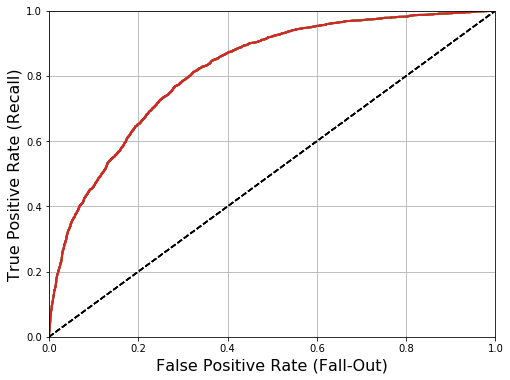

In [150]:
plt.figure(figsize=(8, 6))                                
plot_roc_curve(fpr, tpr)
plot_roc_curve(fpr_Ridge, tpr_Ridge) 
plot_roc_curve(fpr_Lasso, tpr_Lasso)
plot_roc_curve(fpr_elasticnet, tpr_elasticnet) 
plt.show()

Print the AUC score of ROC curve for the four models

According to AUC scores, Logistic Regression without any regularization, with L2 penalty, with L1 penalty, and with Elastic Net penalty all have similar scores. The AUC scores of models with L1 and Elastric Net penalty are slightly higher than models with none regularization and L2 penalty, which means the first two models perform slightly better in this trial.

However, we would want to use a Cross-Validation method to verify if the same pattern exists when we run multiple times with different sets of training and validation data. 

In [151]:
from sklearn.metrics import roc_auc_score
print("The AUC score of Logistic regression without any regularization is : " +str(roc_auc_score(treatment_labels,y_scores)))
print("The AUC score of Logistic regression with L2 panelty is : " +str(roc_auc_score(treatment_labels,y_scores_Ridge)))
print("The AUC score of Logistic regression with L1 panelty is : " +str(roc_auc_score(treatment_labels,y_scores_Lasso)))
print("The AUC score of Logistic regression with elasticNet panelty is : " +str(roc_auc_score(treatment_labels,y_scores_elasticnet)))

The AUC score of Logistic regression without any regularization is : 0.8187316527735188
The AUC score of Logistic regression with L2 panelty is : 0.818736288344595
The AUC score of Logistic regression with L1 panelty is : 0.8187401153858324
The AUC score of Logistic regression with elasticNet panelty is : 0.8187366656585199


#### Use Cross-Validation method for evaluting different models

Define a function to calculate a set of AUC scores for each model (Geron, 2019)

In [152]:
from sklearn.model_selection import cross_val_score

def cross_val_scores(model, treatment_prepared, treatment_labels):
    AUC = cross_val_score(model, treatment_prepared, treatment_labels,
                             scoring="roc_auc", cv=10)

    print(str(model)+" AUC of Cross-Validation equals to ")
    print("AUC: ", AUC) 
    print("Mean: ", AUC.mean()) 
    print("Standard Deviation: ", AUC.std()) 
    print('\n')

Run all four models again with Cross-Validation method and print their mean and standard deviation (SD) scores of their AUC values

According to the descriptive information of AUC scores of all four models, we see that it demonstrates a consistent pattern with the last step. All four models have similar mean and standard deviation (SD) scores, while the models with no regularization and L2 penalty have SD scores that are slightly higher than the other models, indicating that there might be more variation in their AUC scores. 

In [153]:
models = [clf_none, clf_Ridge, clf_Lasso, clf_elasticnet]
for model in models:
    cross_val_scores(model,treatment_prepared, treatment_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) AUC of Cross-Validation equals to 
AUC:  [0.82794231 0.80794112 0.81335283 0.81890086 0.81251616 0.8315194
 0.80641703 0.81489763 0.82876078 0.82445582]
Mean:  0.8186703936772617
Standard Deviation:  0.008556006307940253


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) AUC of Cross-Validation equals to 
AUC:  [0.8279531  0.8079735  0.81337981 0.81892241 0.8125431  0.83150862
 0.80641164 0.81487

#### Model Fine-Tuning

In [154]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib

Use RandomizedSearchCV method to randomly test a series of models with different parameter settings (Geron, 2019; Sklearn Documentation, 2020).

In this step, we first run this method on Logistic Regression models with L2 and none penalty because they are most flexible by using different solvers compared to the other two models. 

Save the best model for the test data. 

In [155]:
# Define the range of parameter setting for Linear Regression model
param_distribs = {
    'penalty':['l2','none'],
    'solver':['newton-cg','lbfgs','sag','saga'],
    }
clf=LogisticRegression()

# Run RandomizedSearchCV method on Linear Regression by randomly selecting parameters within the range 
rnd_search = RandomizedSearchCV(clf, param_distributions=param_distribs,
                                n_iter=10, cv=15, scoring='roc_auc', random_state=42)
rnd_search.fit(treatment_prepared, treatment_labels)

# Compute AUC scores of all randomly performed parameter settings and print their AUC values 
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

# Identify the best Logistic Regression model from the models generated 
best_estimator = rnd_search.best_estimator_
best_models=[]
best_models.append(best_estimator)
print(best_estimator)

# Save the current best model for future usage 
joblib.dump(best_estimator,'model/best_l2_model.pkl')

/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/o

0.8185297038431796 {'solver': 'newton-cg', 'penalty': 'l2'}
0.8185313213576261 {'solver': 'lbfgs', 'penalty': 'l2'}
0.8185297038431796 {'solver': 'sag', 'penalty': 'l2'}
0.8185288933921522 {'solver': 'saga', 'penalty': 'l2'}
0.8185264722018951 {'solver': 'newton-cg', 'penalty': 'none'}
0.8185264722018951 {'solver': 'lbfgs', 'penalty': 'none'}
0.81852809310395 {'solver': 'sag', 'penalty': 'none'}
0.8185264688142868 {'solver': 'saga', 'penalty': 'none'}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


['model/best_l2_model.pkl']

Use RandomizedSearchCV method to randomly test a series of models with different parameter settings (Geron, 2019; Sklearn Documentation, 2020).

In this step, we will run this method on Logistic Regression models with Elastic Net penalty with different l1_ratio settings. The reason we skip the model with L1 penalty is that we can achieve L1 effect by setting the L1_ratio to 1 and achieve L2 effect by setting the ratio to 0. (Sklean Documentation, 2020).

Save the best model for the test data. 

In [156]:
# Define the range of parameter setting for Linear Regression model
param_distribs = {
    'penalty':['elasticnet'],
    'l1_ratio':randint(low=0, high=1)
    }
clf=LogisticRegression(solver='saga')

# Run RandomizedSearchCV method on Linear Regression by randomly selecting parameters within the range 
rnd_search = RandomizedSearchCV(clf, param_distributions=param_distribs,
                                n_iter=10, cv=15, scoring='roc_auc', random_state=42)
rnd_search.fit(treatment_prepared, treatment_labels)

# Compute RMSE scores of all randomly performed parameter settings and print their RMSE values 
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

# Identify the best Linear Regression model from the models generated 
best_estimator = rnd_search.best_estimator_
best_models.append(best_estimator)
print(best_estimator)

# Save the current best model for future usage 
joblib.dump(best_estimator,'model/best_elasticnet_model.pkl')

/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
0.8185288933921522 {'l1_ratio': 0, 'penalty': 'elasticnet'}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


/Users/joycejiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


['model/best_elasticnet_model.pkl']

Print the best models from the two rounds of cross-validation. 

Here we observe a pattern that both rounds identify Logistic Regression models with L2 penalty as the best models. Therefore, we will mainly use the model with L2 penalty for the test data. 

In [157]:
best_models

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False)]

### Step 6: Evalute Models on the Test Data

#### AUC score, Confusion Matrix, Precision and Recall scores

Read the saved model: Logistic Regression with L2 Penalty

In [158]:
model=joblib.load('model/best_l2_model.pkl')

Applied data transformation and full pipline transformation to the test data and define response (Y) and predictors (X) in the test data. Use the selected L2 model for predicting the response variable (treatment)

In [159]:
df=data_transform(strat_test_set) # perform data pre-transformation 
X_test = df.drop("treatment", axis=1) # separate dependent and independent variables 
y_test = df["treatment"].copy()

X_test_prepared = full_pipeline.transform(X_test) # perform data pipline transformation
final_predictions = model.predict(X_test_prepared) # use the saved model to predict test data

Use cross-validation method to collect a series of true positive and false postive rates with differnt threshold settings and assign true positive and false positive rates of different threholds to fpr and tpr arrays (Geron, 2019). 

Define a function to plot the ROC curve for the selected model (Geron, 2019).

In [160]:
#Use cross-validation method to collect a series of true positive and false postive rates with differnt threshold settings (Geron, 2019)
y_scores = cross_val_predict(model, X_test_prepared, y_test, cv=3,
                             method="decision_function")

#Assign true positive and false positive rates of different threholds to fpr and tpr arrays (Geron, 2019)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)


# Define a function to plot the ROC curve of the selected model (Geron, 2019)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

Plot the ROC curve of the selected Logistic Regression model with the L2 penalty.

The ROC of the best model with the test data shows similar trend with the curves there were generated in the premilitary analysis on the training dataset, which means the best model is robust in classifying the treatment recommendation. 

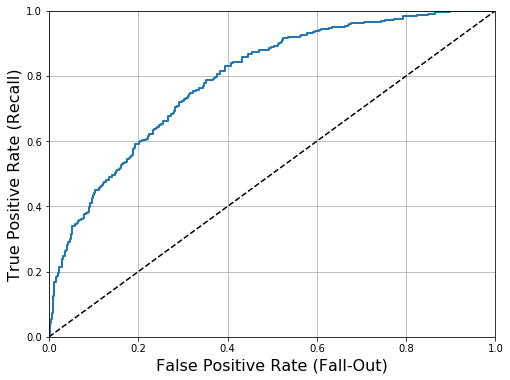

In [161]:
plt.figure(figsize=(8, 6))                                
plot_roc_curve(fpr, tpr)
plt.show()

Print the AUC, Precision, Recall, and F1 scores of the selected model.

The best model receives an AUC score of 0.79 which is also close to the AUC scores of the training data, which double confirms the robustness of the Logistic Regression model with L2 penalty. 

In [162]:
from sklearn.metrics import f1_score

print("The AUC score of the best model is : " +str(roc_auc_score(y_test,y_scores)))
print("The precision score of the best model is : " +str(precision_score(y_test,final_predictions)))
print("The recall score of the best model is : " +str(recall_score(y_test,final_predictions)))
print("The F1 score of the best model is : " +str(f1_score(y_test,final_predictions)))

The AUC score of the best model is : 0.7910592686002522
The precision score of the best model is : 0.6988847583643123
The recall score of the best model is : 0.48205128205128206
The F1 score of the best model is : 0.5705614567526555


Print the confusion matrix of the selected model

In [163]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,final_predictions)

array([[529,  81],
       [202, 188]])

Plot the precision and recall vs threshold.

Conclusion: 
The model has a satisfying precision score, while the recall score that is slightly below 0.50 has more room for improvement. The relatively low recall score indicates that the model does not have an optimal performance in providing recommendation for patients who need treatment. At the same time, the precision score indicates that among all patients who have received recommendation based on the model classification, majority of them indeed need treatment as recommended. 

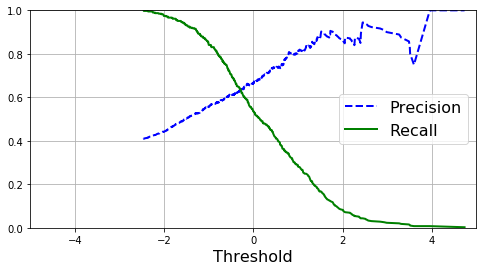

In [164]:
#Plot the precision and recall vs threshold (Geron, 2019)
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test,y_scores) #(Geron, 2019)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)      
    plt.grid(True)                            
    plt.axis([-5, 5, 0, 1])            


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)         
plt.show()

#### Feature Importance

Brownlee, J. (2020). How to Calculate Feature Importance With Python. Machine Learning Mastery. Retrieved from https://machinelearningmastery.com/calculate-feature-importance-with-python/

This project use coefficient scores for feature importance measurement (Brownlee, 2020). 

By comparing five numerical and two categorical variables of the four models, TestB (absolute value), Gender, Age, Blood Pressure are the most important features in the best model. 

In [165]:
importance = model.coef_

feartures=['age','blood_pressure','TestB','GeneB','GeneC','female','non-female','blood_test_negative','blood_test_positive','GeneA_none','GeneA_double','GeneA_single']
dictionary = list(zip(feartures,importance[0]))
importance_df=pd.DataFrame(dictionary, columns=['feartures','importance'])

In [166]:
importance_df

,feartures,importance
0,age,-0.456847
1,blood_pressure,0.374746
2,TestB,1.022731
3,GeneB,0.087800
4,GeneC,0.133591
5,female,-0.918664
6,non-female,0.918519
7,blood_test_negative,0.337742
8,blood_test_positive,-0.337888
